<a href="https://colab.research.google.com/github/iam-pattan/DL-lab/blob/main/DA_2(Lic_Plate_detection).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!gdown --id 1kDt_wxMMcuomtJdfLRStHT-R7WvRDGc-

Downloading...
From: https://drive.google.com/uc?id=1kDt_wxMMcuomtJdfLRStHT-R7WvRDGc-
To: /content/Licence_Plate.zip
13.9MB [00:00, 84.7MB/s]


In [ ]:
!unzip Licence_Plate.zip

In [ ]:
!rm -r '/content/__results___files'

In [ ]:
!wget "https://pjreddie.com/media/files/yolov3.weights"

--2021-05-18 08:19:56--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights’

yolov3.weights      100%[===================>] 236.52M  69.0MB/s    in 3.4s    

2021-05-18 08:20:00 (69.0 MB/s) - ‘yolov3.weights’ saved [248007048/248007048]



In [ ]:
!wget "https://raw.githubusercontent.com/anuj200199/licenseplatedetection/master/yolo-obj.cfg"

--2021-05-18 08:20:00--  https://raw.githubusercontent.com/anuj200199/licenseplatedetection/master/yolo-obj.cfg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9128 (8.9K) [text/plain]
Saving to: ‘yolo-obj.cfg’

yolo-obj.cfg        100%[===================>]   8.91K  --.-KB/s    in 0s      

2021-05-18 08:20:00 (94.7 MB/s) - ‘yolo-obj.cfg’ saved [9128/9128]



In [ ]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv('/content/indian_license_plates.csv')

In [ ]:
df.head()

,image_name,image_width,image_height,top_x,top_y,bottom_x,bottom_y
0,licensed_car0,806,466,0.722084,0.587983,0.868486,0.688841
1,licensed_car1,494,449,0.161943,0.850780,0.582996,1.000000
2,licensed_car2,500,314,0.082000,0.697452,0.230000,0.828025
3,licensed_car3,500,469,0.434000,0.667377,0.718000,0.765458
4,licensed_car4,1001,563,0.208791,0.390764,0.865135,0.984014


In [ ]:
df["image_name"] = df["image_name"] + ".jpeg"
df.drop(["image_width", "image_height"], axis=1, inplace=True)
df.head()

,image_name,top_x,top_y,bottom_x,bottom_y
0,licensed_car0.jpeg,0.722084,0.587983,0.868486,0.688841
1,licensed_car1.jpeg,0.161943,0.850780,0.582996,1.000000
2,licensed_car2.jpeg,0.082000,0.697452,0.230000,0.828025
3,licensed_car3.jpeg,0.434000,0.667377,0.718000,0.765458
4,licensed_car4.jpeg,0.208791,0.390764,0.865135,0.984014


In [ ]:
widths,heights =[],[]
center_x,center_y=[],[]
for i in range(len(df)):
    widths.append(df['bottom_x'][i]- df['top_x'][i])
    heights.append(df['bottom_y'][i]- df['top_y'][i])
    center_x.append((df['bottom_x'][i] + df['top_x'][i])/2)
    center_y.append((df['bottom_y'][i] + df['top_y'][i])/2)
lic = pd.DataFrame(columns=['x','y','w','h'])
lic['w'] = widths
lic['h'] = heights
lic['x'] = center_x
lic['y'] = center_y

In [ ]:
lic.head()

,x,y,w,h
0,0.795285,0.638412,0.146402,0.100858
1,0.372470,0.925390,0.421053,0.149220
2,0.156000,0.762739,0.148000,0.130573
3,0.576000,0.716418,0.284000,0.098081
4,0.536963,0.687389,0.656344,0.593250


In [ ]:
WIDTH = 224
HEIGHT = 224
CHANNEL = 3

def show_img(index):
    image = cv2.imread("Indian Number Plates/" + df["image_name"].iloc[index])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, dsize=(WIDTH, HEIGHT))

    tx = int(df["top_x"].iloc[index] * WIDTH)
    ty = int(df["top_y"].iloc[index] * HEIGHT)
    bx = int(df["bottom_x"].iloc[index] * WIDTH)
    by = int(df["bottom_y"].iloc[index] * HEIGHT)

    image = cv2.rectangle(image, (tx, ty), (bx, by), (0, 0, 255), 1)
    plt.imshow(image)
    plt.show()

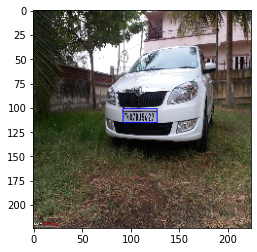

In [ ]:
show_img(8)

In [ ]:
import os
# derive the paths to the YOLO weights and model configuration
weightsPath = os.path.sep.join(["/content", "yolov3.weights"])
configPath = os.path.sep.join(["/content", "yolo-obj.cfg"])

In [ ]:
import cv2
import argparse
import numpy as np
from google.colab.patches import cv2_imshow


def get_output_layers(net):
    
    layer_names = net.getLayerNames()
    
    output_layers = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]

    return output_layers


def draw_prediction(img, class_id, confidence, x, y, x_plus_w, y_plus_h):

    label = str(classes[class_id])

    color = COLORS[class_id]

    cv2.rectangle(img, (x,y), (x_plus_w,y_plus_h), color, 2)

    cv2.putText(img, label, (x-10,y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    image=img[y:y_plus_h,x:x_plus_w]
    cv2_imshow(image)
    cv2.imwrite("trying.jpg",image)

   
image = cv2.imread('/content/Indian Number Plates/licensed_car109.jpeg')

Width = image.shape[1]
Height = image.shape[0]
scale = 0.00392

classes = None
pth = '/content/indian_license_plates.csv'
with open(pth, 'r') as f:
    classes = [line.strip() for line in f.readlines()]

COLORS = np.random.uniform(0, 255, size=(len(classes), 3))

net = cv2.dnn.readNet(weightsPath, configPath)

blob = cv2.dnn.blobFromImage(image, scale, (416,416), (0,0,0), True, crop=False)

net.setInput(blob)

outs = net.forward(get_output_layers(net))

In [ ]:
class_ids = []
confidences = []
boxes = []
conf_threshold = 0.5
nms_threshold = 0.4

In [ ]:
#only consider predictions greater than 0.5
for out in outs:
    for detection in out:
        scores = detection[5:]
        class_id = np.argmax(scores)
        confidence = scores[class_id]
        if confidence > 0.5:
            center_x = int(detection[0] * Width)
            center_y = int(detection[1] * Height)
            w = int(detection[2] * Width)
            h = int(detection[3] * Height)
            x = center_x - w / 2
            y = center_y - h / 2
            class_ids.append(class_id)
            confidences.append(float(confidence))
            boxes.append([x, y, w, h])

In [ ]:
indices = cv2.dnn.NMSBoxes(boxes, confidences, conf_threshold, nms_threshold)

print(indices)

()


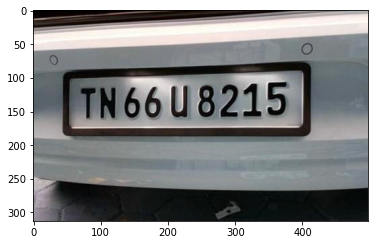

In [ ]:
indices = cv2.dnn.NMSBoxes(boxes, confidences, conf_threshold, nms_threshold)

for i in indices:
    i = i[0]
    box = boxes[i]
    x = box[0]
    y = box[1]
    w = box[2]
    h = box[3]
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, dsize=(WIDTH, HEIGHT))
    #draw_prediction(image, class_ids[i], confidences[i], round(x), round(y), round(x+w), round(y+h))
    image = cv2.rectangle(image, (round(x), round(y)), (round(w), round(h)), (0, 0, 255), 1)
plt.imshow(image)
plt.show()


In [ ]:
!pip install pytesseract
!pip install tesseract

In [ ]:
!sudo apt-get install tesseract-ocr

In [ ]:
tessdata_dir_config = '--tessdata-dir "/usr/local/lib/python3.7/dist-packages/pytesseract"'

License Plate : ——————————“‘ié‘C;‘;SF
O°

'TN66U8215



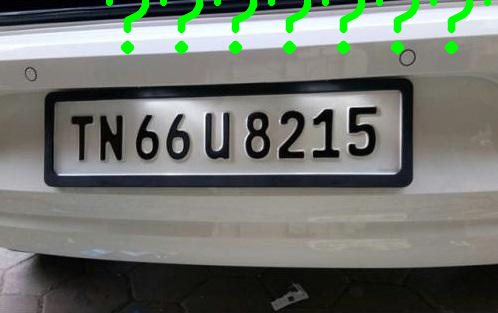

-1

In [ ]:
import pytesseract

license_plate = cv2.bilateralFilter(image, 11, 17, 17)
text = pytesseract.image_to_string(license_plate)
image = cv2.putText(image, text, (100,50), cv2.FONT_HERSHEY_SIMPLEX, 3, (0,255,0), 6, cv2.LINE_AA)

print("License Plate :", text)

cv2_imshow(image)
cv2.waitKey(0)

In [ ]:
text

"——————————“‘ié‘C;‘;SF\nO°\n\n'TN66U8215\n\x0c"

In [ ]:
text1 = [i for i in text if i.isalnum()]
" ".join(text1)

'i é C S F O T N 6 6 U 8 2 1 5'